In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Unzip Wang.zip into /content/wang_dataset
import zipfile
import os

zip_path = "/content/drive/MyDrive/Dataset/Wang.zip"  # 🔁 Change if needed
extract_path = "/content/drive/MyDrive/Dataset/wang_dataset/Wang"

# Extract only if not already done
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print(f"✅ Extracted Wang dataset to: {extract_path}")


✅ Extracted Wang dataset to: /content/drive/MyDrive/Dataset/wang_dataset/Wang


In [ ]:
from glob import glob

# Collect all .jpg image paths from extracted Wang dataset
image_paths = glob(os.path.join(extract_path, "*.jpg"))
print(f"Found {len(image_paths)} images in the WANG dataset.")


Found 9908 images in the WANG dataset.


In [ ]:
# 🔁 Path to your extracted image folder
DATASET_PATH = "/content/drive/MyDrive/Dataset/wang_dataset/Wang"
CROP_SAVE_PATH = "/content/outputs/crops"
QUERY_CROP_PATH = "/content/outputs/query_crops"

# Create output folders
import os
os.makedirs(CROP_SAVE_PATH, exist_ok=True)
os.makedirs(QUERY_CROP_PATH, exist_ok=True)


In [ ]:
from PIL import Image, ImageOps, ImageFilter
import numpy as np

def preprocess_image(image_path, target_size=(512, 512), apply_filters=True):
    """
    Preprocess image:
    - Convert to RGB
    - Resize to fixed size
    - Optionally apply smoothing or sharpening
    """
    try:
        img = Image.open(image_path)

        # Convert to RGB if not already
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Resize while maintaining aspect ratio and padding
        img = ImageOps.pad(img, target_size, method=Image.BICUBIC)

        # Optional filters
        if apply_filters:
            img = img.filter(ImageFilter.SHARPEN)
            img = img.filter(ImageFilter.SMOOTH)

        return img
    except Exception as e:
        print(f"Error preprocessing {image_path}: {e}")
        return None


In [ ]:
def crop_objects_from_image(image_path, save_folder):
    os.makedirs(save_folder, exist_ok=True)

    # 🔁 Preprocess first
    image = preprocess_image(image_path, target_size=(512, 512))
    if image is None:
        return []

    results = yolo_model(image)

    crops = []
    for i, box in enumerate(results[0].boxes.xyxy.cpu().numpy()):
        x1, y1, x2, y2 = map(int, box)
        cropped = image.crop((x1, y1, x2, y2))
        crop_path = os.path.join(save_folder, f"{os.path.basename(image_path)}_obj{i}.jpg")
        cropped.save(crop_path)
        crops.append((crop_path, cropped))
    return crops


In [ ]:
PREPROCESSED_DIR = "/content/preprocessed_wang"
os.makedirs(PREPROCESSED_DIR, exist_ok=True)

for img_path in image_paths:
    img = preprocess_image(img_path)
    if img:
        out_path = os.path.join(PREPROCESSED_DIR, os.path.basename(img_path))
        img.save(out_path)

# 🔁 Replace original paths with preprocessed paths for rest of pipeline
image_paths = glob(os.path.join(PREPROCESSED_DIR, "*.jpg"))


In [ ]:
!pip install -q diffusers transformers accelerate


In [ ]:
from diffusers import StableDiffusionPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pre-trained stable diffusion model
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
pipe = pipe.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def get_yolo_object_labels(image_path):
    results = yolo_model(image_path)
    class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
    class_names = [yolo_model.names[c] for c in class_ids]
    return list(set(class_names))  # return unique labels


In [ ]:
from PIL import Image
from IPython.display import display

def generate_similar_images_from_yolo(image_path, num_images=3):
    # Get object labels using YOLO
    detected_classes = get_yolo_object_labels(image_path)
    print("Detected object classes:", detected_classes)

    # Generate prompts for each class and generate images
    for obj_class in detected_classes:
        prompt = f"a photo of a {obj_class}"
        print(f"\nGenerating images for: '{prompt}'")

        images = pipe(prompt, num_images_per_prompt=num_images, guidance_scale=7.5).images
        for i, img in enumerate(images):
            save_path = f"/content/generated_{obj_class}_{i}.png"
            img.save(save_path)
            display(img)


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Dataset/wang_dataset/Wang"


In [ ]:
import os

# List some files in the dataset folder
print("Files found in dataset folder:")
print(os.listdir(DATASET_PATH)[:10])


Files found in dataset folder:
['9015.jpg', '9016.jpg', '9017.jpg', '9018.jpg', '9019.jpg', '902.jpg', '9020.jpg', '9021.jpg', '9022.jpg', '9023.jpg']


In [ ]:
from glob import glob

# Match .jpg, .jpeg, .JPG, .png
image_paths = []
for ext in ['*.jpg', '*.jpeg', '*.JPG', '*.png']:
    image_paths.extend(glob(os.path.join(DATASET_PATH, ext)))

print(f"✅ Found {len(image_paths)} images.")


✅ Found 9908 images.


In [ ]:
# ✅ Install Ultralytics YOLOv8
!pip install -q ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.9 MB/s eta 0:00:00


In [ ]:
# ✅ Load YOLOv8 after installing
from ultralytics import YOLO

yolo_model = YOLO('yolov8m.pt')  # or 'yolov8n.pt' if you want a faster, lighter model


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.



image 1/1 /content/drive/MyDrive/Dataset/wang_dataset/Wang/9015.jpg: 480x640 2 persons, 320.2ms
Speed: 16.9ms preprocess, 320.2ms inference, 429.1ms postprocess per image at shape (1, 3, 480, 640)
Detected object classes: ['person']

Generating images for: 'a photo of a person'


  0%|          | 0/50 [00:00<?, ?it/s]

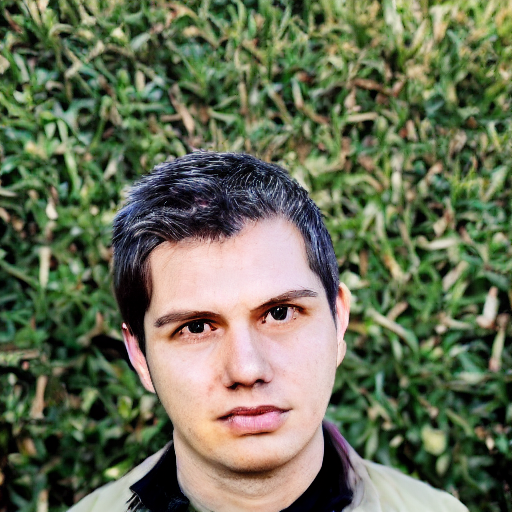

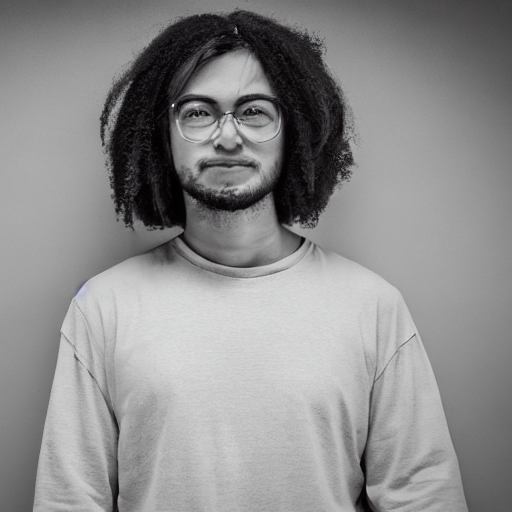

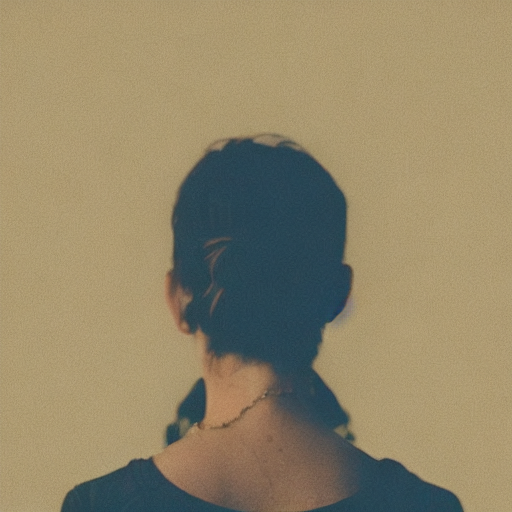

In [ ]:
query_image = image_paths[0]
generate_similar_images_from_yolo(query_image, num_images=3)


In [ ]:
# Show all 80 class names YOLOv8 is trained to detect
for i, name in yolo_model.names.items():
    print(f"{i}: {name}")



0: person
1: bicycle
2: car
3: motorcycle
4: airplane
5: bus
6: train
7: truck
8: boat
9: traffic light
10: fire hydrant
11: stop sign
12: parking meter
13: bench
14: bird
15: cat
16: dog
17: horse
18: sheep
19: cow
20: elephant
21: bear
22: zebra
23: giraffe
24: backpack
25: umbrella
26: handbag
27: tie
28: suitcase
29: frisbee
30: skis
31: snowboard
32: sports ball
33: kite
34: baseball bat
35: baseball glove
36: skateboard
37: surfboard
38: tennis racket
39: bottle
40: wine glass
41: cup
42: fork
43: knife
44: spoon
45: bowl
46: banana
47: apple
48: sandwich
49: orange
50: broccoli
51: carrot
52: hot dog
53: pizza
54: donut
55: cake
56: chair
57: couch
58: potted plant
59: bed
60: dining table
61: toilet
62: tv
63: laptop
64: mouse
65: remote
66: keyboard
67: cell phone
68: microwave
69: oven
70: toaster
71: sink
72: refrigerator
73: book
74: clock
75: vase
76: scissors
77: teddy bear
78: hair drier
79: toothbrush


In [ ]:
!pip install -q ftfy regex tqdm torchvision clip
!pip install -q diffusers transformers accelerate


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00


In [ ]:
# # 1️⃣ Remove the wrong package
!pip uninstall -y clip

# # 2️⃣ Install the correct CLIP directly from OpenAI's GitHub
!pip install git+https://github.com/openai/CLIP.git


Found existing installation: clip 0.2.0
Uninstalling clip-0.2.0:
  Successfully uninstalled clip-0.2.0
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-o4wpqnjs
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-o4wpqnjs
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=977df2a990a6a94c119599a8b0e2cdeed16dadf6a1686e7b1515727d65a179ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-w4j0iqdn/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
# 3️⃣ Import and use it
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:20<00:00, 17.7MiB/s]


In [ ]:
# Candidate prompts based on WANG dataset categories
candidate_prompts = [
    "a photo of a flower",
    "a photo of a dinosaur",
    "a photo of a beach",
    "a photo of a mountain",
    "a photo of a building",
    "a photo of an elephant",
    "a photo of a horse",
    "a photo of African people",
    "a photo of food",
    "a photo of a bus"
]


In [ ]:
def generate_clip_prompt(image_path, prompts=candidate_prompts):
    image = clip_preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = clip.tokenize(prompts).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text)

        # Compute similarity
        similarity = torch.nn.functional.cosine_similarity(image_features, text_features)
        best_match_index = similarity.argmax().item()
        return prompts[best_match_index]


In [ ]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
pipe = pipe.to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
from IPython.display import display

def generate_images_from_clip(image_path, num_images=3):
    # Step 1: Generate prompt
    prompt = generate_clip_prompt(image_path)
    print(f"📝 CLIP Prompt: {prompt}")

    # Step 2: Generate images
    images = pipe(prompt, num_images_per_prompt=num_images, guidance_scale=7.5).images

    # Step 3: Save + display
    for i, img in enumerate(images):
        filename = f"/content/generated_clip_{i}.png"
        img.save(filename)
        display(img)


📝 CLIP Prompt: a photo of a dinosaur


  0%|          | 0/50 [00:00<?, ?it/s]

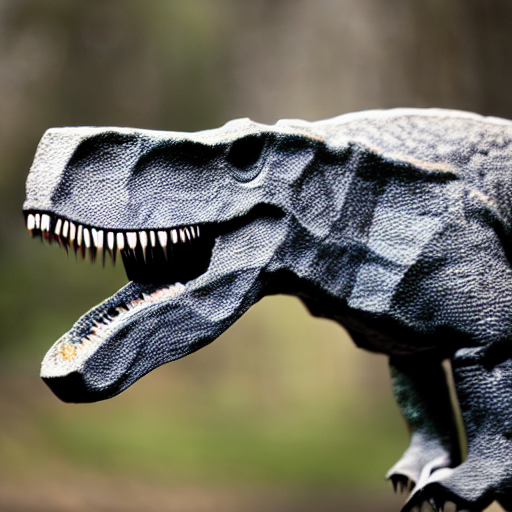

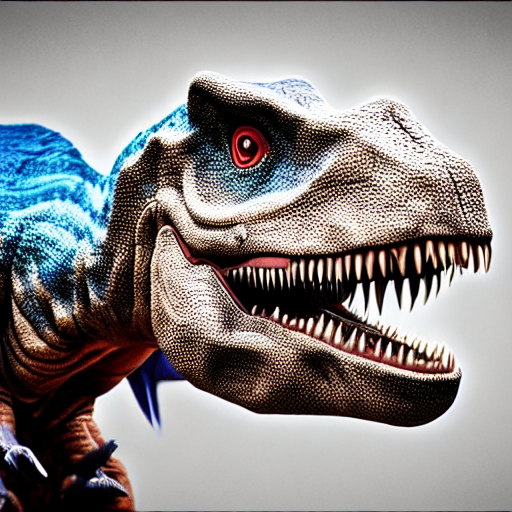

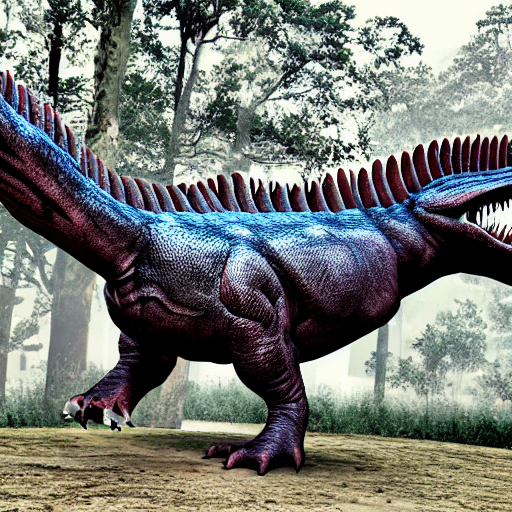

In [ ]:
# Choose an image from your dataset
from glob import glob
image_paths = glob("/content/drive/MyDrive/Dataset/wang_dataset/Wang/*.jpg")  # Update if needed

# Run generation
query_image = image_paths[10]
generate_images_from_clip(query_image, num_images=3)


In [ ]:
# Install dependencies
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q faiss-cpu diffusers transformers accelerate gradio


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 26.2 MB/s eta 0:00:00


In [ ]:
# Load CLIP
import clip
import torch
from PIL import Image
import os
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Load Stable Diffusion
from diffusers import StableDiffusionPipeline
sd_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
from glob import glob
import faiss

# Load dataset image paths
dataset_path = "/content/drive/MyDrive/Dataset/wang_dataset/Wang"
image_paths = glob(os.path.join(dataset_path, "*.jpg"))

# Preprocess + embed
all_embeddings = []
valid_paths = []

for path in image_paths:
    try:
        img = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = clip_model.encode_image(img).cpu().numpy()[0]
        all_embeddings.append(emb)
        valid_paths.append(path)
    except:
        continue

# Build FAISS index
embeddings_np = np.array(all_embeddings).astype("float32")
faiss_index = faiss.IndexFlatL2(embeddings_np.shape[1])
faiss_index.add(embeddings_np)


In [ ]:
def generate_from_text(prompt, num_images=3):
    images = sd_pipe(prompt, num_images_per_prompt=num_images, guidance_scale=7.5).images
    return images


In [ ]:
def retrieve_similar_images(uploaded_image, k=5):
    # Convert uploaded PIL image
    img_tensor = clip_preprocess(uploaded_image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_embedding = clip_model.encode_image(img_tensor).cpu().numpy().astype("float32")

    D, I = faiss_index.search(query_embedding, k)
    return [valid_paths[i] for i in I[0]]  # Return file paths of matches


In [ ]:
# TEXT to IMAGE GENERATION (with improved prompt control)
from PIL import Image
from IPython.display import display

def generate_from_text(prompt="a photo of a flower", num_images=3):
    print(f"🔤 Prompt: {prompt}")
    output = sd_pipe(prompt,
                     num_images_per_prompt=num_images,
                     guidance_scale=8.5,
                     num_inference_steps=50)
    for i, img in enumerate(output.images):
        display(img)


🔤 Prompt: a bouquet of realistic red roses in a glass vase, ultra detailed


  0%|          | 0/50 [00:00<?, ?it/s]

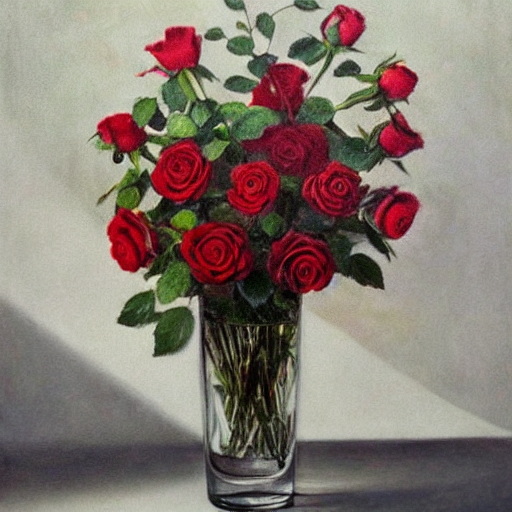

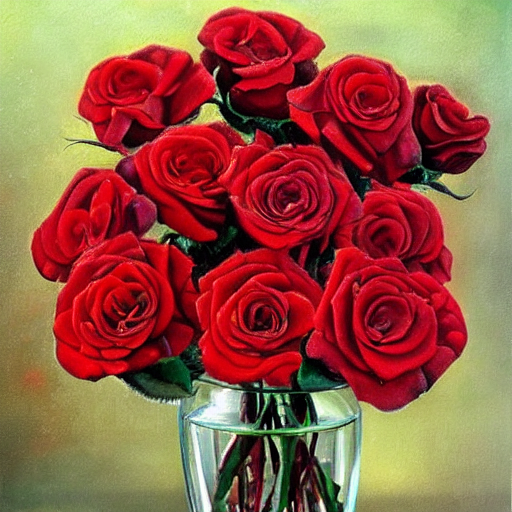

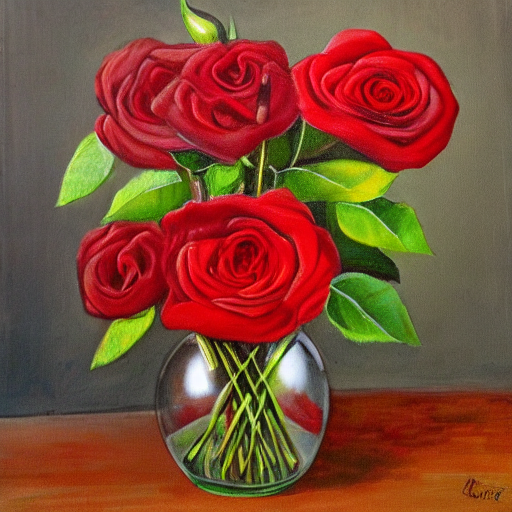

In [ ]:
generate_from_text("a bouquet of realistic red roses in a glass vase, ultra detailed", num_images=3)


In [ ]:
# IMAGE to IMAGE RETRIEVAL
def retrieve_similar_images(uploaded_image, k=5):
    img_tensor = clip_preprocess(uploaded_image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_embedding = clip_model.encode_image(img_tensor).cpu().numpy().astype("float32")

    D, I = faiss_index.search(query_embedding, k)

    print("🔁 Top similar images:")
    for i in I[0]:
        display(Image.open(valid_paths[i]))


In [ ]:
img = Image.open(image_paths[10])  # Try with a known beach/mountain/bus/etc
retrieve_similar_images(img, k=5)


In [ ]:
import os

def get_label_from_path(path):
    return os.path.basename(os.path.dirname(path))

# Build ground truth list
true_labels = [get_label_from_path(p) for p in valid_paths]
label_to_index = {label: i for i, label in enumerate(sorted(set(true_labels)))}
index_to_label = {v: k for k, v in label_to_index.items()}

# Encode labels as ints for metrics
true_labels_idx = [label_to_index[label] for label in true_labels]


In [ ]:
from collections import Counter

def predict_label(query_img, k=5):
    similar_paths = retrieve_similar_images(query_img, k)
    predicted_labels = [get_label_from_path(p) for p in similar_paths]
    most_common_label = Counter(predicted_labels).most_common(1)[0][0]
    return label_to_index[most_common_label]


In [ ]:
def retrieve_similar_images(uploaded_image, k=5):
    img_tensor = clip_preprocess(uploaded_image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_embedding = clip_model.encode_image(img_tensor).cpu().numpy().astype("float32")

    D, I = faiss_index.search(query_embedding, k)

    # ✅ RETURN list of image paths for use in predictions
    return [valid_paths[i] for i in I[0]]


In [ ]:
predicted_labels_idx = []
query_labels_idx = []

for i, path in enumerate(valid_paths):
    img = Image.open(path).convert("RGB")
    pred = predict_label(img, k=5)
    predicted_labels_idx.append(pred)
    query_labels_idx.append(true_labels_idx[i])


In [ ]:
# Filter valid image paths to only include 0.jpg to 999.jpg
def is_valid_wang_image(path):
    try:
        index = int(os.path.splitext(os.path.basename(path))[0])
        return index < 1000
    except:
        return False

# Apply filter
valid_paths = [p for p in valid_paths if is_valid_wang_image(p)]
print(f"✅ Valid WANG image count: {len(valid_paths)}")  # should be 1000


In [ ]:
# Categories based on WANG class order
wang_categories = [
    "african", "beach", "building", "bus", "dinosaur",
    "elephant", "flower", "horse", "mountain", "food"
]

# Label from file index
def get_label_from_path(path):
    index = int(os.path.splitext(os.path.basename(path))[0])
    class_id = index // 100
    return wang_categories[class_id]

# Build label mappings
true_labels = [get_label_from_path(p) for p in valid_paths]
label_to_index = {label: i for i, label in enumerate(wang_categories)}
index_to_label = {i: label for label, i in label_to_index.items()}
true_labels_idx = [label_to_index[label] for label in true_labels]


In [ ]:
import numpy as np
import faiss

all_embeddings = []

for path in valid_paths:
    try:
        img = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = clip_model.encode_image(img).cpu().numpy()[0]
        all_embeddings.append(emb)
    except:
        continue

embeddings_np = np.array(all_embeddings).astype("float32")
faiss_index = faiss.IndexFlatL2(embeddings_np.shape[1])
faiss_index.add(embeddings_np)

print(f"✅ Rebuilt FAISS index with {len(valid_paths)} WANG images.")


In [ ]:
predicted_labels_idx = []
query_labels_idx = []

for i, path in enumerate(valid_paths):
    img = Image.open(path).convert("RGB")
    pred = predict_label(img, k=5)
    predicted_labels_idx.append(pred)
    query_labels_idx.append(true_labels_idx[i])


In [ ]:
from collections import Counter
from PIL import Image

# Predict label based on majority of top-k retrieved images
def predict_label(query_img, k=5):
    similar_paths = retrieve_similar_images(query_img, k)
    predicted_labels = [get_label_from_path(p) for p in similar_paths]
    most_common_label = Counter(predicted_labels).most_common(1)[0][0]
    return label_to_index[most_common_label]

# Predict for all WANG images
predicted_labels_idx = []
query_labels_idx = []

for i, path in enumerate(valid_paths):
    img = Image.open(path).convert("RGB")
    pred = predict_label(img, k=5)
    predicted_labels_idx.append(pred)
    query_labels_idx.append(true_labels_idx[i])


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(query_labels_idx, predicted_labels_idx)
print(f"✅ Model Accuracy: {accuracy:.4f}")

# Print classification metrics
report = classification_report(
    query_labels_idx,
    predicted_labels_idx,
    target_names=wang_categories
)
print("\n🧾 Classification Report:\n")
print(report)


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

n_classes = len(wang_categories)
y_true_bin = label_binarize(query_labels_idx, classes=list(range(n_classes)))
y_pred_bin = label_binarize(predicted_labels_idx, classes=list(range(n_classes)))

roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro")
print(f"🎯 ROC AUC Score (macro-average): {roc_auc:.4f}")


In [ ]:
with open("wang_retrieval_report.txt", "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"ROC AUC: {roc_auc:.4f}\n")
    f.write(report)


In [ ]:
!apt-get install -y graphviz
!pip install graphviz


In [ ]:
import torch

# 1️⃣ Save YOLOv8 (weights only)
yolo_model_path = "yolo_object_detection_model.pth"
torch.save(yolo_model.model.state_dict(), yolo_model_path)
print(f"✅ Saved YOLOv8 weights to {yolo_model_path}")

# 2️⃣ Save CLIP model
clip_model_path = "clip_image_text_model.pth"
torch.save(clip_model.state_dict(), clip_model_path)
print(f"✅ Saved CLIP model to {clip_model_path}")

# 3️⃣ Save Stable Diffusion components separately
sd_unet_path = "stable_diffusion_unet.pth"
sd_vae_path = "stable_diffusion_vae.pth"
sd_text_encoder_path = "stable_diffusion_text_encoder.pth"

torch.save(pipe.unet.state_dict(), sd_unet_path)
torch.save(pipe.vae.state_dict(), sd_vae_path)
torch.save(pipe.text_encoder.state_dict(), sd_text_encoder_path)

print(f"✅ Saved Stable Diffusion UNet to {sd_unet_path}")
print(f"✅ Saved Stable Diffusion VAE to {sd_vae_path}")
print(f"✅ Saved Stable Diffusion Text Encoder to {sd_text_encoder_path}")


In [ ]:
torch.save(clip_model.state_dict(), "clip_retrieval.pth")


In [ ]:
torch.save(pipe.unet.state_dict(), "stable_diffusion_unet.pth")
